In [1]:
import torch;
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import pandas as pd
import torchvision.models as models 
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.optim import lr_scheduler
import seaborn as sns
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import copy
from tqdm import tqdm
#from model import VAE

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from dataloader_pw import *
from cnn_model_1 import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
#only on validation set
csv_path = 'pairwise_lstm.csv'
img_path = '/home/vip/sayan-mandal/datasets/obj_criteria/good_reduced/'

CDL = PWDataLoader(csv_path, img_path, transform = transforms.Compose([transforms.Resize(64),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

#random sampler
batch_size = 64
validation_split = .2
test_split = .2
train_split = 1-validation_split-test_split
shuffle_dataset = True

# Creating data indices for training and validation splits:
dataset_size = len(CDL)
indices = list(range(dataset_size))
split_train = int(np.floor(train_split * dataset_size))
split_valid = int(np.floor((train_split+validation_split) * dataset_size))
if shuffle_dataset :
    np.random.shuffle(indices)
train_indices, val_indices, test_indices =  indices[:split_train],indices[split_train:split_valid],indices[split_valid:]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=test_sampler)

<AxesSubplot:xlabel='Slope ($\\mu$m/y)', ylabel='Count'>

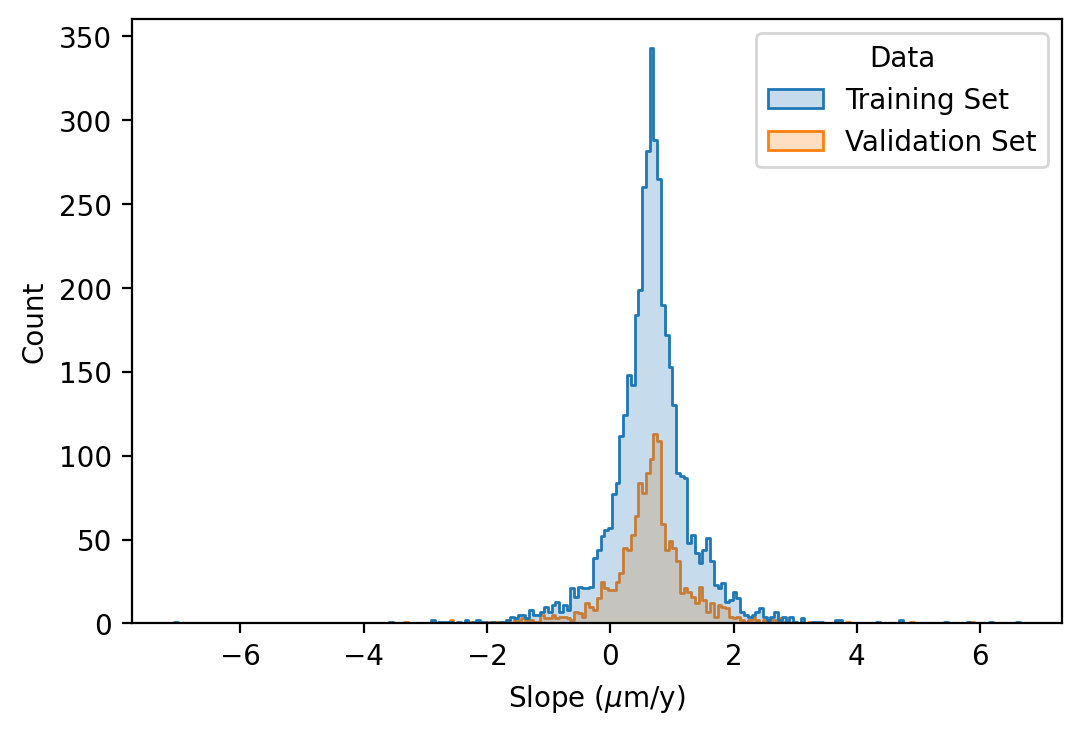

In [4]:

for batch_idx, (_, targets, _) in enumerate(train_loader):
    targets = Variable(targets.view(targets.shape[0],-1))

    if batch_idx == 0:
        true_scores = targets.cpu().numpy()
    else:
        true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)

for batch_idx, (_, targets, _) in enumerate(valid_loader):
    targets = Variable(targets.view(targets.shape[0],-1))

    if batch_idx == 0:
        valtrue_scores = targets.cpu().numpy()
    else:
        valtrue_scores = np.append(valtrue_scores, targets.cpu().numpy(), axis = 0)

from scipy.stats import ks_2samp
dfx = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': true_scores.ravel().tolist(), 'Data':'Training Set'})
dfy = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': valtrue_scores.ravel().tolist(), 'Data':'Validation Set'})
df = pd.concat(axis=0, ignore_index=True, objs=[dfx,dfy])



fig,ax = plt.subplots()
sns.histplot(df,x='Slope ($\mu$m/y)',hue='Data',ax=ax, element='step')


In [5]:
print(len(true_scores), len(valtrue_scores))

4445 1482


In [6]:
torch.cuda.empty_cache()
tl = iter(train_loader)
dat,_,_ = next(tl)
bs, ts, C, H, W = dat.shape
n_out = 1
print(ts)

model = CNNLSTMNet(channels = C, ts = ts, n_out = n_out, device = device).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)  #,momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[120], gamma= 0.1)
criterion = nn.MSELoss()  # this is for regression mean squared loss

2


In [7]:
epochs = 200
best_loss =float('inf')
ep, trainloss, validloss, testloss = [],[],[],[]
testep, totloss = [],[]
besttrloss, bestvalloss, besttsloss = 0,0,0
for epoch in range(1,epochs+1):
    model.train()
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    trloss = 0
    for batch_idx, (data, targets, _) in loop:
        optimizer.zero_grad() 
        data = Variable(data).to(device)
        targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

        #forward pass
        scores = model(data)
        loss = criterion(scores, targets)
        trloss += loss.item()
        #backward pass   
        loss.backward()

        #gradient descent
        optimizer.step()
        loop.set_description(f"Epoch [{epoch}/{epochs}]")
        loop.set_postfix(batch_loss = loss.item(), running_loss = trloss )
    scheduler.step()

    model.eval()
    valloss = 0
    with torch.no_grad():
        for data, targets, _ in valid_loader:
            data = Variable(data).to(device)
            targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

            
            scores = model(data)
            loss = criterion(scores, targets)

            valloss += loss.item()

    if valloss < best_loss:
        tsloss = 0
        with torch.no_grad():
            for data, targets, _ in test_loader:
                data = Variable(data).to(device)
                targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

                
                scores = model(data)
                loss = criterion(scores, targets)

                tsloss += loss.item()
            testloss += [tsloss]
            testep += [epoch]
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f} ===========> {:.4f} | Test Loss: {:.4f} | Saving model...".format(trloss, best_loss, valloss, tsloss)
        best_loss = valloss
        bestvalloss = valloss
        besttrloss = trloss
        besttsloss = tsloss
        best_e = epoch
        torch.save(model.state_dict(),'pw_statedict.pt')
        #best_model = copy.deepcopy(model)
    else:
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f}".format(trloss, valloss)

    print(to_print)
    ep+=[epoch]
    trainloss += [trloss]
    validloss += [valloss]
    totloss += [trloss + valloss]

Epoch [1/200]: 100%|██████████| 70/70 [00:08<00:00,  7.79it/s, batch_loss=0.273, running_loss=32.2]


Train Loss: 32.2282 | Valid Loss: inf ===========> 10.6749 | Test Loss: 11.0415 | Saving model...


Epoch [2/200]: 100%|██████████| 70/70 [00:09<00:00,  7.17it/s, batch_loss=0.327, running_loss=31]


Train Loss: 30.9768 | Valid Loss: 10.6749 ===========> 10.3450 | Test Loss: 11.9418 | Saving model...


Epoch [3/200]: 100%|██████████| 70/70 [00:09<00:00,  7.45it/s, batch_loss=0.232, running_loss=30]


Train Loss: 30.0096 | Valid Loss: 10.3450 ===========> 9.9774 | Test Loss: 11.5845 | Saving model...


Epoch [4/200]: 100%|██████████| 70/70 [00:09<00:00,  7.41it/s, batch_loss=0.334, running_loss=29.2]


Train Loss: 29.1547 | Valid Loss: 9.9774 ===========> 9.8771 | Test Loss: 10.6103 | Saving model...


Epoch [5/200]: 100%|██████████| 70/70 [00:09<00:00,  7.39it/s, batch_loss=0.477, running_loss=27.4]


Train Loss: 27.4256 | Valid Loss: 12.9665


Epoch [6/200]: 100%|██████████| 70/70 [00:09<00:00,  7.31it/s, batch_loss=0.288, running_loss=26.4]


Train Loss: 26.4287 | Valid Loss: 10.1650


Epoch [7/200]: 100%|██████████| 70/70 [00:09<00:00,  7.45it/s, batch_loss=0.151, running_loss=24.9]


Train Loss: 24.8571 | Valid Loss: 9.8771 ===========> 8.5318 | Test Loss: 9.0231 | Saving model...


Epoch [8/200]: 100%|██████████| 70/70 [00:09<00:00,  7.44it/s, batch_loss=0.181, running_loss=24]


Train Loss: 23.9712 | Valid Loss: 8.5318 ===========> 8.1553 | Test Loss: 8.8128 | Saving model...


Epoch [9/200]: 100%|██████████| 70/70 [00:09<00:00,  7.36it/s, batch_loss=0.456, running_loss=21.6]


Train Loss: 21.6040 | Valid Loss: 8.1553 ===========> 7.9198 | Test Loss: 8.3838 | Saving model...


Epoch [10/200]: 100%|██████████| 70/70 [00:09<00:00,  7.42it/s, batch_loss=0.312, running_loss=20.1]


Train Loss: 20.0902 | Valid Loss: 8.7358


Epoch [11/200]: 100%|██████████| 70/70 [00:09<00:00,  7.41it/s, batch_loss=0.306, running_loss=20.2]


Train Loss: 20.1591 | Valid Loss: 8.0673


Epoch [12/200]: 100%|██████████| 70/70 [00:09<00:00,  7.42it/s, batch_loss=0.128, running_loss=18.2]


Train Loss: 18.1583 | Valid Loss: 8.4284


Epoch [13/200]: 100%|██████████| 70/70 [00:09<00:00,  7.44it/s, batch_loss=0.245, running_loss=17.1]


Train Loss: 17.1121 | Valid Loss: 7.9198 ===========> 7.8282 | Test Loss: 8.2102 | Saving model...


Epoch [14/200]: 100%|██████████| 70/70 [00:09<00:00,  7.35it/s, batch_loss=0.177, running_loss=15.6]


Train Loss: 15.6059 | Valid Loss: 7.8282 ===========> 6.9941 | Test Loss: 7.1506 | Saving model...


Epoch [15/200]: 100%|██████████| 70/70 [00:09<00:00,  7.35it/s, batch_loss=0.146, running_loss=15.4]


Train Loss: 15.3893 | Valid Loss: 7.8850


Epoch [16/200]: 100%|██████████| 70/70 [00:09<00:00,  7.41it/s, batch_loss=0.106, running_loss=15]


Train Loss: 14.9912 | Valid Loss: 6.9941 ===========> 6.8061 | Test Loss: 7.4805 | Saving model...


Epoch [17/200]: 100%|██████████| 70/70 [00:09<00:00,  7.46it/s, batch_loss=0.0867, running_loss=13.1]


Train Loss: 13.1217 | Valid Loss: 6.8061 ===========> 6.6142 | Test Loss: 7.0963 | Saving model...


Epoch [18/200]: 100%|██████████| 70/70 [00:09<00:00,  7.51it/s, batch_loss=0.143, running_loss=12.9]


Train Loss: 12.9218 | Valid Loss: 6.6142 ===========> 6.4945 | Test Loss: 6.8935 | Saving model...


Epoch [19/200]: 100%|██████████| 70/70 [00:09<00:00,  7.30it/s, batch_loss=0.192, running_loss=11.4]


Train Loss: 11.4344 | Valid Loss: 7.3522


Epoch [20/200]: 100%|██████████| 70/70 [00:09<00:00,  7.44it/s, batch_loss=0.305, running_loss=12.6]


Train Loss: 12.5507 | Valid Loss: 7.1250


Epoch [21/200]: 100%|██████████| 70/70 [00:09<00:00,  7.36it/s, batch_loss=0.143, running_loss=11.2]


Train Loss: 11.2006 | Valid Loss: 6.7053


Epoch [22/200]: 100%|██████████| 70/70 [00:09<00:00,  7.39it/s, batch_loss=0.0724, running_loss=10.9]


Train Loss: 10.8519 | Valid Loss: 6.4945 ===========> 6.1241 | Test Loss: 6.4058 | Saving model...


Epoch [23/200]: 100%|██████████| 70/70 [00:09<00:00,  7.47it/s, batch_loss=0.121, running_loss=9.95]


Train Loss: 9.9525 | Valid Loss: 6.6599


Epoch [24/200]: 100%|██████████| 70/70 [00:09<00:00,  7.36it/s, batch_loss=0.0945, running_loss=8.97]


Train Loss: 8.9711 | Valid Loss: 6.8521


Epoch [25/200]: 100%|██████████| 70/70 [00:09<00:00,  7.47it/s, batch_loss=0.106, running_loss=8.45]


Train Loss: 8.4485 | Valid Loss: 6.1807


Epoch [26/200]: 100%|██████████| 70/70 [00:09<00:00,  7.41it/s, batch_loss=0.0933, running_loss=8.73]


Train Loss: 8.7300 | Valid Loss: 7.0168


Epoch [27/200]: 100%|██████████| 70/70 [00:09<00:00,  7.41it/s, batch_loss=0.175, running_loss=7.62]


Train Loss: 7.6213 | Valid Loss: 6.4807


Epoch [28/200]: 100%|██████████| 70/70 [00:09<00:00,  7.48it/s, batch_loss=0.0473, running_loss=6.57]


Train Loss: 6.5737 | Valid Loss: 6.1241 ===========> 5.9946 | Test Loss: 6.1068 | Saving model...


Epoch [29/200]: 100%|██████████| 70/70 [00:09<00:00,  7.37it/s, batch_loss=0.05, running_loss=6.59]


Train Loss: 6.5945 | Valid Loss: 5.9980


Epoch [30/200]: 100%|██████████| 70/70 [00:09<00:00,  7.47it/s, batch_loss=0.121, running_loss=6.25]


Train Loss: 6.2516 | Valid Loss: 5.9946 ===========> 5.9816 | Test Loss: 5.9674 | Saving model...


Epoch [31/200]: 100%|██████████| 70/70 [00:09<00:00,  7.47it/s, batch_loss=0.042, running_loss=5.53]


Train Loss: 5.5321 | Valid Loss: 6.0701


Epoch [32/200]: 100%|██████████| 70/70 [00:09<00:00,  7.46it/s, batch_loss=0.0684, running_loss=5.56]


Train Loss: 5.5629 | Valid Loss: 5.9816 ===========> 5.8575 | Test Loss: 5.9975 | Saving model...


Epoch [33/200]: 100%|██████████| 70/70 [00:09<00:00,  7.40it/s, batch_loss=0.0484, running_loss=4.78]


Train Loss: 4.7827 | Valid Loss: 6.0887


Epoch [34/200]: 100%|██████████| 70/70 [00:09<00:00,  7.36it/s, batch_loss=0.0478, running_loss=4.77]


Train Loss: 4.7712 | Valid Loss: 6.7622


Epoch [35/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.139, running_loss=4.84]


Train Loss: 4.8383 | Valid Loss: 5.8837


Epoch [36/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0412, running_loss=4.23]


Train Loss: 4.2292 | Valid Loss: 6.2751


Epoch [37/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0609, running_loss=4.17]


Train Loss: 4.1750 | Valid Loss: 5.9902


Epoch [38/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0505, running_loss=3.55]


Train Loss: 3.5481 | Valid Loss: 5.8575 ===========> 5.7166 | Test Loss: 5.6976 | Saving model...


Epoch [39/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0264, running_loss=3.71]


Train Loss: 3.7112 | Valid Loss: 5.7166 ===========> 5.6495 | Test Loss: 5.7607 | Saving model...


Epoch [40/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0402, running_loss=3.61]


Train Loss: 3.6109 | Valid Loss: 5.9773


Epoch [41/200]: 100%|██████████| 70/70 [00:09<00:00,  7.55it/s, batch_loss=0.0665, running_loss=3.13]


Train Loss: 3.1308 | Valid Loss: 5.7942


Epoch [42/200]: 100%|██████████| 70/70 [00:09<00:00,  7.58it/s, batch_loss=0.0351, running_loss=3.05]


Train Loss: 3.0516 | Valid Loss: 6.2081


Epoch [43/200]: 100%|██████████| 70/70 [00:09<00:00,  7.58it/s, batch_loss=0.0334, running_loss=2.9]


Train Loss: 2.8962 | Valid Loss: 5.7698


Epoch [44/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0583, running_loss=3.13]


Train Loss: 3.1317 | Valid Loss: 5.8593


Epoch [45/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0539, running_loss=2.83]


Train Loss: 2.8291 | Valid Loss: 5.7969


Epoch [46/200]: 100%|██████████| 70/70 [00:09<00:00,  7.55it/s, batch_loss=0.0591, running_loss=2.73]


Train Loss: 2.7304 | Valid Loss: 5.8426


Epoch [47/200]: 100%|██████████| 70/70 [00:09<00:00,  7.57it/s, batch_loss=0.0252, running_loss=2.62]


Train Loss: 2.6247 | Valid Loss: 5.8052


Epoch [48/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0332, running_loss=2.49]


Train Loss: 2.4870 | Valid Loss: 5.8737


Epoch [49/200]: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s, batch_loss=0.0416, running_loss=2.58]


Train Loss: 2.5813 | Valid Loss: 5.7920


Epoch [50/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0179, running_loss=2.49]


Train Loss: 2.4887 | Valid Loss: 5.8725


Epoch [51/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0319, running_loss=2.36]


Train Loss: 2.3618 | Valid Loss: 6.0020


Epoch [52/200]: 100%|██████████| 70/70 [00:09<00:00,  7.54it/s, batch_loss=0.033, running_loss=2.4]


Train Loss: 2.4009 | Valid Loss: 5.7821


Epoch [53/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.0297, running_loss=2.36]


Train Loss: 2.3602 | Valid Loss: 5.7344


Epoch [54/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0337, running_loss=2.22]


Train Loss: 2.2196 | Valid Loss: 5.8761


Epoch [55/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0288, running_loss=2.25]


Train Loss: 2.2518 | Valid Loss: 5.6922


Epoch [56/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.043, running_loss=2.43]


Train Loss: 2.4274 | Valid Loss: 5.6824


Epoch [57/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.02, running_loss=2.06]


Train Loss: 2.0650 | Valid Loss: 5.7336


Epoch [58/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0278, running_loss=2.09]


Train Loss: 2.0950 | Valid Loss: 6.0429


Epoch [59/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0144, running_loss=2.04]


Train Loss: 2.0391 | Valid Loss: 5.6495 ===========> 5.6441 | Test Loss: 5.5520 | Saving model...


Epoch [60/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0247, running_loss=2.07]


Train Loss: 2.0694 | Valid Loss: 5.7667


Epoch [61/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0319, running_loss=1.9]


Train Loss: 1.8982 | Valid Loss: 5.7601


Epoch [62/200]: 100%|██████████| 70/70 [00:09<00:00,  7.58it/s, batch_loss=0.0198, running_loss=1.97]


Train Loss: 1.9727 | Valid Loss: 6.3717


Epoch [63/200]: 100%|██████████| 70/70 [00:09<00:00,  7.55it/s, batch_loss=0.026, running_loss=2.01]


Train Loss: 2.0131 | Valid Loss: 5.7823


Epoch [64/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0151, running_loss=1.95]


Train Loss: 1.9509 | Valid Loss: 5.8398


Epoch [65/200]: 100%|██████████| 70/70 [00:09<00:00,  7.71it/s, batch_loss=0.0428, running_loss=1.92]


Train Loss: 1.9217 | Valid Loss: 5.8170


Epoch [66/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0283, running_loss=1.89]


Train Loss: 1.8859 | Valid Loss: 5.6448


Epoch [67/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0245, running_loss=1.86]


Train Loss: 1.8584 | Valid Loss: 5.9232


Epoch [68/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0143, running_loss=1.65]


Train Loss: 1.6516 | Valid Loss: 5.6629


Epoch [69/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0326, running_loss=1.82]


Train Loss: 1.8174 | Valid Loss: 5.6887


Epoch [70/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0457, running_loss=1.85]


Train Loss: 1.8502 | Valid Loss: 5.7591


Epoch [71/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0212, running_loss=1.86]


Train Loss: 1.8590 | Valid Loss: 5.7185


Epoch [72/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0405, running_loss=1.67]


Train Loss: 1.6675 | Valid Loss: 5.9610


Epoch [73/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0698, running_loss=1.81]


Train Loss: 1.8139 | Valid Loss: 5.6950


Epoch [74/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0169, running_loss=1.8]


Train Loss: 1.7953 | Valid Loss: 5.6441 ===========> 5.6296 | Test Loss: 5.5705 | Saving model...


Epoch [75/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0181, running_loss=1.75]


Train Loss: 1.7508 | Valid Loss: 5.6474


Epoch [76/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0204, running_loss=1.67]


Train Loss: 1.6738 | Valid Loss: 5.8681


Epoch [77/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0334, running_loss=1.72]


Train Loss: 1.7239 | Valid Loss: 5.9341


Epoch [78/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0274, running_loss=1.72]


Train Loss: 1.7157 | Valid Loss: 6.0326


Epoch [79/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0407, running_loss=1.63]


Train Loss: 1.6338 | Valid Loss: 5.6296 ===========> 5.6067 | Test Loss: 5.5662 | Saving model...


Epoch [80/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0216, running_loss=1.78]


Train Loss: 1.7831 | Valid Loss: 5.6412


Epoch [81/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0191, running_loss=1.65]


Train Loss: 1.6501 | Valid Loss: 6.0566


Epoch [82/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0755, running_loss=1.64]


Train Loss: 1.6354 | Valid Loss: 5.6668


Epoch [83/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0345, running_loss=1.64]


Train Loss: 1.6428 | Valid Loss: 5.7192


Epoch [84/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0234, running_loss=1.6]


Train Loss: 1.6018 | Valid Loss: 5.7521


Epoch [85/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0262, running_loss=1.56]


Train Loss: 1.5613 | Valid Loss: 5.6067 ===========> 5.5684 | Test Loss: 5.6098 | Saving model...


Epoch [86/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.0095, running_loss=1.54]


Train Loss: 1.5440 | Valid Loss: 5.6561


Epoch [87/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0288, running_loss=1.5]


Train Loss: 1.5045 | Valid Loss: 5.7156


Epoch [88/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0139, running_loss=1.46]


Train Loss: 1.4598 | Valid Loss: 5.6432


Epoch [89/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.011, running_loss=1.52]


Train Loss: 1.5186 | Valid Loss: 5.6724


Epoch [90/200]: 100%|██████████| 70/70 [00:09<00:00,  7.56it/s, batch_loss=0.0191, running_loss=1.54]


Train Loss: 1.5392 | Valid Loss: 5.5684 ===========> 5.4786 | Test Loss: 5.5921 | Saving model...


Epoch [91/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0205, running_loss=1.51]


Train Loss: 1.5112 | Valid Loss: 5.6884


Epoch [92/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0271, running_loss=1.44]


Train Loss: 1.4361 | Valid Loss: 5.6711


Epoch [93/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.061, running_loss=1.49]


Train Loss: 1.4903 | Valid Loss: 6.4160


Epoch [94/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.0252, running_loss=1.51]


Train Loss: 1.5117 | Valid Loss: 5.6579


Epoch [95/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0175, running_loss=1.47]


Train Loss: 1.4738 | Valid Loss: 5.8335


Epoch [96/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0317, running_loss=1.51]


Train Loss: 1.5117 | Valid Loss: 5.8353


Epoch [97/200]: 100%|██████████| 70/70 [00:09<00:00,  7.54it/s, batch_loss=0.0252, running_loss=1.49]


Train Loss: 1.4885 | Valid Loss: 5.7959


Epoch [98/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.11, running_loss=1.48]


Train Loss: 1.4775 | Valid Loss: 5.6797


Epoch [99/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0248, running_loss=1.45]


Train Loss: 1.4544 | Valid Loss: 5.7620


Epoch [100/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0265, running_loss=1.5]


Train Loss: 1.5021 | Valid Loss: 5.6803


Epoch [101/200]: 100%|██████████| 70/70 [00:09<00:00,  7.55it/s, batch_loss=0.0204, running_loss=1.39]


Train Loss: 1.3877 | Valid Loss: 5.5424


Epoch [102/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0148, running_loss=1.34]


Train Loss: 1.3442 | Valid Loss: 5.7747


Epoch [103/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0301, running_loss=1.37]


Train Loss: 1.3663 | Valid Loss: 5.6227


Epoch [104/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0196, running_loss=1.36]


Train Loss: 1.3564 | Valid Loss: 5.5697


Epoch [105/200]: 100%|██████████| 70/70 [00:09<00:00,  7.57it/s, batch_loss=0.0436, running_loss=1.42]


Train Loss: 1.4238 | Valid Loss: 5.6182


Epoch [106/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.0166, running_loss=1.42]


Train Loss: 1.4189 | Valid Loss: 5.9580


Epoch [107/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0229, running_loss=1.37]


Train Loss: 1.3689 | Valid Loss: 5.7558


Epoch [108/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0169, running_loss=1.34]


Train Loss: 1.3353 | Valid Loss: 5.9964


Epoch [109/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.022, running_loss=1.38]


Train Loss: 1.3794 | Valid Loss: 6.1112


Epoch [110/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0246, running_loss=1.37]


Train Loss: 1.3729 | Valid Loss: 5.9412


Epoch [111/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0158, running_loss=1.32]


Train Loss: 1.3250 | Valid Loss: 5.5700


Epoch [112/200]: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s, batch_loss=0.0147, running_loss=1.39]


Train Loss: 1.3921 | Valid Loss: 6.3328


Epoch [113/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0153, running_loss=1.35]


Train Loss: 1.3502 | Valid Loss: 5.6468


Epoch [114/200]: 100%|██████████| 70/70 [00:09<00:00,  7.71it/s, batch_loss=0.0321, running_loss=1.33]


Train Loss: 1.3287 | Valid Loss: 5.7112


Epoch [115/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0381, running_loss=1.31]


Train Loss: 1.3114 | Valid Loss: 5.8136


Epoch [116/200]: 100%|██████████| 70/70 [00:09<00:00,  7.58it/s, batch_loss=0.0253, running_loss=1.4]


Train Loss: 1.4035 | Valid Loss: 5.6850


Epoch [117/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.024, running_loss=1.31]


Train Loss: 1.3116 | Valid Loss: 5.6032


Epoch [118/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0613, running_loss=1.36]


Train Loss: 1.3637 | Valid Loss: 5.7740


Epoch [119/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.00601, running_loss=1.31]


Train Loss: 1.3076 | Valid Loss: 5.7022


Epoch [120/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0282, running_loss=1.25]


Train Loss: 1.2533 | Valid Loss: 6.3527


Epoch [121/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.00719, running_loss=1.2]


Train Loss: 1.2021 | Valid Loss: 5.6490


Epoch [122/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0101, running_loss=1.14]


Train Loss: 1.1437 | Valid Loss: 5.7755


Epoch [123/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0195, running_loss=1.16]


Train Loss: 1.1628 | Valid Loss: 5.6697


Epoch [124/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0152, running_loss=1.18]


Train Loss: 1.1773 | Valid Loss: 5.6875


Epoch [125/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0214, running_loss=1.1]


Train Loss: 1.1015 | Valid Loss: 5.9795


Epoch [126/200]: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s, batch_loss=0.0335, running_loss=1.1]


Train Loss: 1.0958 | Valid Loss: 5.6583


Epoch [127/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0235, running_loss=1.11]


Train Loss: 1.1070 | Valid Loss: 5.6548


Epoch [128/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0185, running_loss=1.11]


Train Loss: 1.1148 | Valid Loss: 5.6248


Epoch [129/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0258, running_loss=1.12]


Train Loss: 1.1229 | Valid Loss: 5.6453


Epoch [130/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0256, running_loss=1.15]


Train Loss: 1.1513 | Valid Loss: 5.6014


Epoch [131/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0175, running_loss=1.1]


Train Loss: 1.0999 | Valid Loss: 5.5594


Epoch [132/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0171, running_loss=1.09]


Train Loss: 1.0916 | Valid Loss: 5.6632


Epoch [133/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0248, running_loss=1.11]


Train Loss: 1.1150 | Valid Loss: 5.5697


Epoch [134/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.049, running_loss=1.12]


Train Loss: 1.1171 | Valid Loss: 5.6654


Epoch [135/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.00849, running_loss=1.08]


Train Loss: 1.0821 | Valid Loss: 5.5904


Epoch [136/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.00735, running_loss=1.09]


Train Loss: 1.0885 | Valid Loss: 5.6486


Epoch [137/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0221, running_loss=1.08]


Train Loss: 1.0806 | Valid Loss: 5.5675


Epoch [138/200]: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s, batch_loss=0.0192, running_loss=1.09]


Train Loss: 1.0914 | Valid Loss: 5.5965


Epoch [139/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0092, running_loss=1.07]


Train Loss: 1.0661 | Valid Loss: 5.6462


Epoch [140/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0343, running_loss=1.09]


Train Loss: 1.0920 | Valid Loss: 5.6361


Epoch [141/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0204, running_loss=1.02]


Train Loss: 1.0238 | Valid Loss: 5.6326


Epoch [142/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.00886, running_loss=1.07]


Train Loss: 1.0663 | Valid Loss: 5.6271


Epoch [143/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0147, running_loss=1.03]


Train Loss: 1.0261 | Valid Loss: 5.5556


Epoch [144/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.00953, running_loss=1.1]


Train Loss: 1.0997 | Valid Loss: 5.7565


Epoch [145/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0145, running_loss=1.06]


Train Loss: 1.0579 | Valid Loss: 5.6727


Epoch [146/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0131, running_loss=1.06]


Train Loss: 1.0633 | Valid Loss: 6.3510


Epoch [147/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0173, running_loss=1.08]


Train Loss: 1.0818 | Valid Loss: 5.5764


Epoch [148/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0139, running_loss=1.05]


Train Loss: 1.0506 | Valid Loss: 6.1328


Epoch [149/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0176, running_loss=1.06]


Train Loss: 1.0628 | Valid Loss: 5.7281


Epoch [150/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.00793, running_loss=1.05]


Train Loss: 1.0547 | Valid Loss: 5.8821


Epoch [151/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0099, running_loss=1.02]


Train Loss: 1.0216 | Valid Loss: 6.7212


Epoch [152/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0124, running_loss=1.05]


Train Loss: 1.0549 | Valid Loss: 5.7294


Epoch [153/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0131, running_loss=1.05]


Train Loss: 1.0465 | Valid Loss: 5.5899


Epoch [154/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0278, running_loss=1.06]


Train Loss: 1.0636 | Valid Loss: 5.5455


Epoch [155/200]: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s, batch_loss=0.0115, running_loss=1.05]


Train Loss: 1.0514 | Valid Loss: 5.7639


Epoch [156/200]: 100%|██████████| 70/70 [00:09<00:00,  7.55it/s, batch_loss=0.0351, running_loss=1.04]


Train Loss: 1.0422 | Valid Loss: 5.6339


Epoch [157/200]: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s, batch_loss=0.0107, running_loss=1.09]


Train Loss: 1.0921 | Valid Loss: 5.7566


Epoch [158/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0161, running_loss=1.05]


Train Loss: 1.0506 | Valid Loss: 5.5690


Epoch [159/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0147, running_loss=1.03]


Train Loss: 1.0298 | Valid Loss: 6.0332


Epoch [160/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.0131, running_loss=1.03]


Train Loss: 1.0347 | Valid Loss: 5.5973


Epoch [161/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.00886, running_loss=1.04]


Train Loss: 1.0440 | Valid Loss: 5.5777


Epoch [162/200]: 100%|██████████| 70/70 [00:09<00:00,  7.56it/s, batch_loss=0.00938, running_loss=1.06]


Train Loss: 1.0627 | Valid Loss: 5.7126


Epoch [163/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0209, running_loss=1.02]


Train Loss: 1.0245 | Valid Loss: 5.9623


Epoch [164/200]: 100%|██████████| 70/70 [00:09<00:00,  7.55it/s, batch_loss=0.0162, running_loss=1.09]


Train Loss: 1.0894 | Valid Loss: 5.6159


Epoch [165/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0113, running_loss=1.06]


Train Loss: 1.0607 | Valid Loss: 5.6084


Epoch [166/200]: 100%|██████████| 70/70 [00:09<00:00,  7.48it/s, batch_loss=0.00979, running_loss=1.06]


Train Loss: 1.0564 | Valid Loss: 5.6407


Epoch [167/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0201, running_loss=1.11]


Train Loss: 1.1058 | Valid Loss: 5.7701


Epoch [168/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0117, running_loss=1.08]


Train Loss: 1.0788 | Valid Loss: 5.6115


Epoch [169/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0156, running_loss=1.07]


Train Loss: 1.0705 | Valid Loss: 5.6103


Epoch [170/200]: 100%|██████████| 70/70 [00:09<00:00,  7.58it/s, batch_loss=0.0172, running_loss=1.07]


Train Loss: 1.0685 | Valid Loss: 6.0089


Epoch [171/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.018, running_loss=1.04]


Train Loss: 1.0359 | Valid Loss: 5.5628


Epoch [172/200]: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s, batch_loss=0.0133, running_loss=1.01]


Train Loss: 1.0149 | Valid Loss: 5.5615


Epoch [173/200]: 100%|██████████| 70/70 [00:09<00:00,  7.48it/s, batch_loss=0.0206, running_loss=1]


Train Loss: 1.0041 | Valid Loss: 5.6681


Epoch [174/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.00822, running_loss=1.01]


Train Loss: 1.0091 | Valid Loss: 5.6035


Epoch [175/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0261, running_loss=1.1]


Train Loss: 1.1012 | Valid Loss: 5.5801


Epoch [176/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0277, running_loss=1.09]


Train Loss: 1.0926 | Valid Loss: 5.5925


Epoch [177/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.0126, running_loss=1.02]


Train Loss: 1.0168 | Valid Loss: 5.5909


Epoch [178/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0218, running_loss=1.06]


Train Loss: 1.0626 | Valid Loss: 5.5792


Epoch [179/200]: 100%|██████████| 70/70 [00:09<00:00,  7.58it/s, batch_loss=0.0293, running_loss=1.05]


Train Loss: 1.0528 | Valid Loss: 5.6982


Epoch [180/200]: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s, batch_loss=0.0161, running_loss=1.04]


Train Loss: 1.0424 | Valid Loss: 5.7148


Epoch [181/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0135, running_loss=1.05]


Train Loss: 1.0516 | Valid Loss: 5.5502


Epoch [182/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0124, running_loss=1.06]


Train Loss: 1.0577 | Valid Loss: 5.9082


Epoch [183/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0089, running_loss=1.02]


Train Loss: 1.0196 | Valid Loss: 5.5990


Epoch [184/200]: 100%|██████████| 70/70 [00:09<00:00,  7.58it/s, batch_loss=0.00806, running_loss=1.05]


Train Loss: 1.0462 | Valid Loss: 5.5445


Epoch [185/200]: 100%|██████████| 70/70 [00:09<00:00,  7.54it/s, batch_loss=0.0254, running_loss=1.05]


Train Loss: 1.0493 | Valid Loss: 6.0298


Epoch [186/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0129, running_loss=1.01]


Train Loss: 1.0091 | Valid Loss: 5.6128


Epoch [187/200]: 100%|██████████| 70/70 [00:09<00:00,  7.55it/s, batch_loss=0.0174, running_loss=1.05]


Train Loss: 1.0498 | Valid Loss: 5.5451


Epoch [188/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.00851, running_loss=1.05]


Train Loss: 1.0453 | Valid Loss: 5.5732


Epoch [189/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0238, running_loss=1]


Train Loss: 1.0021 | Valid Loss: 5.5772


Epoch [190/200]: 100%|██████████| 70/70 [00:09<00:00,  7.55it/s, batch_loss=0.0239, running_loss=1.07]


Train Loss: 1.0744 | Valid Loss: 5.7630


Epoch [191/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0213, running_loss=1.04]


Train Loss: 1.0436 | Valid Loss: 5.5751


Epoch [192/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.00958, running_loss=1.04]


Train Loss: 1.0403 | Valid Loss: 5.5731


Epoch [193/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0119, running_loss=1.03]


Train Loss: 1.0330 | Valid Loss: 5.6706


Epoch [194/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.017, running_loss=1.06]


Train Loss: 1.0632 | Valid Loss: 6.0737


Epoch [195/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0176, running_loss=1.05]


Train Loss: 1.0486 | Valid Loss: 5.7606


Epoch [196/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0182, running_loss=1.06]


Train Loss: 1.0610 | Valid Loss: 5.5791


Epoch [197/200]: 100%|██████████| 70/70 [00:09<00:00,  7.57it/s, batch_loss=0.00585, running_loss=1.01]


Train Loss: 1.0060 | Valid Loss: 5.8510


Epoch [198/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0155, running_loss=1.04]


Train Loss: 1.0416 | Valid Loss: 5.6175


Epoch [199/200]: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s, batch_loss=0.0185, running_loss=1.03]


Train Loss: 1.0312 | Valid Loss: 5.7327


Epoch [200/200]: 100%|██████████| 70/70 [00:09<00:00,  7.71it/s, batch_loss=0.0254, running_loss=1.03]


Train Loss: 1.0308 | Valid Loss: 5.5690


Train Loss: 1.5392 | Valid Loss: 5.4786 | Test Loss on Best Model: 5.5921


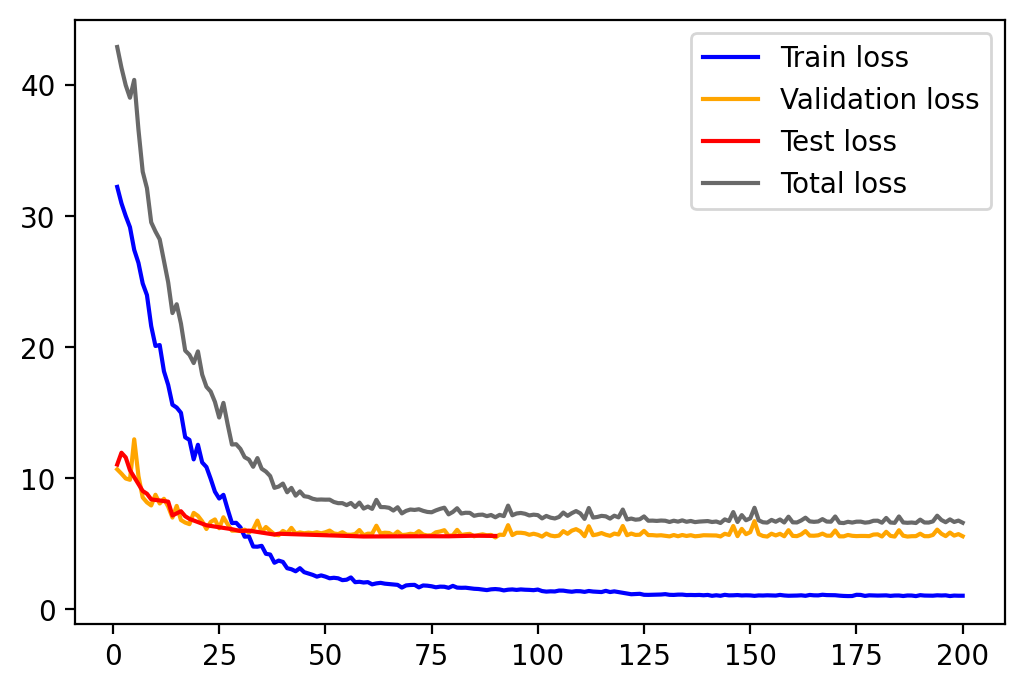

In [8]:
print("Train Loss: {:.4f} | Valid Loss: {:.4f} | Test Loss on Best Model: {:.4f}".format(besttrloss, bestvalloss, besttsloss))
plt.plot(ep,trainloss,color='blue', label = 'Train loss')
plt.plot(ep, validloss, color = 'orange',label = 'Validation loss')
plt.plot(testep, testloss, color = 'red',label = 'Test loss')
plt.plot(ep, totloss, color = 'dimgray',label = 'Total loss')
plt.legend()
plt.show()

In [9]:
tsloss = 0
model.load_state_dict(torch.load('pw_statedict.pt'))
model.eval()
with torch.no_grad():
    for batch_idx, (data, targets, _) in enumerate(test_loader):
        data = Variable(data).to(device)
        targets = Variable(targets.view(targets.shape[0],-1)).to(device)

        
        scores = model(data)
        loss = criterion(scores, targets)

        if batch_idx == 0:
            true_scores = targets.cpu().numpy()
            pred_scores = scores.cpu().numpy()
        else:
            true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)
            pred_scores = np.append(pred_scores, scores.cpu().numpy(), axis = 0)


        tsloss += loss.item()


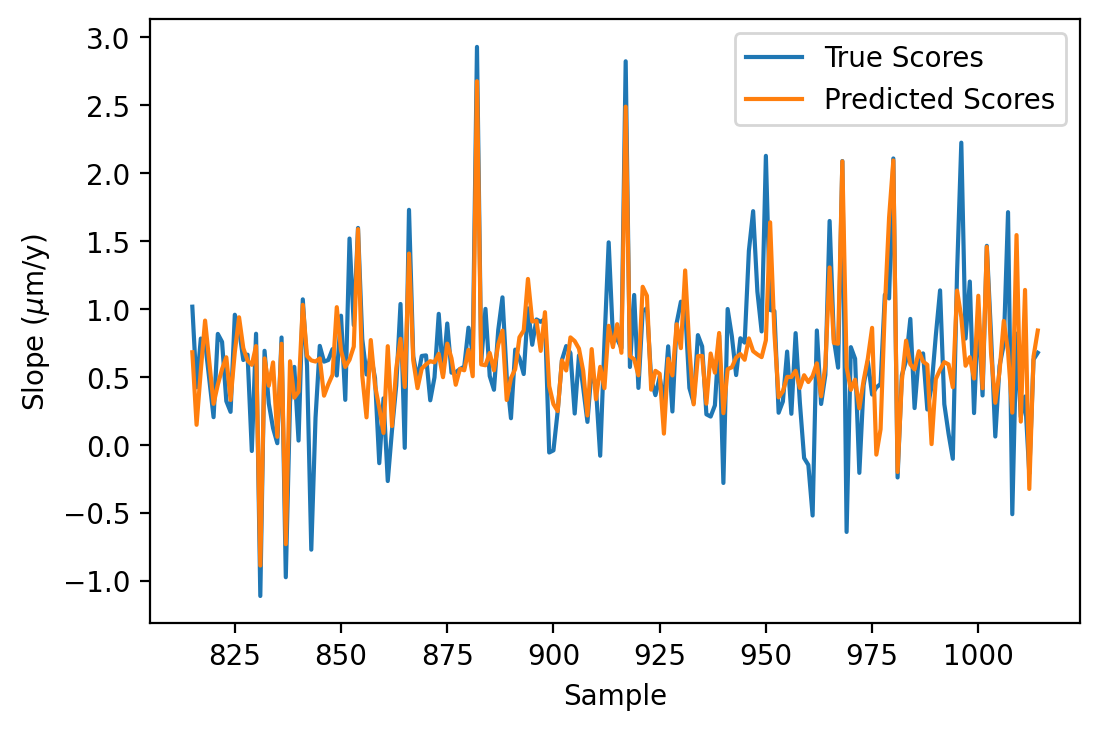

In [10]:
idx = np.array([i+1 for i in range(len(true_scores))])
size = 200
r = np.random.randint(len(idx)-size)
plt.plot(idx[r:r+size], true_scores[r:r+size], label = "True Scores")
plt.plot(idx[r:r+size], pred_scores[r:r+size],label = "Predicted Scores")
plt.ylabel('Slope ($\mu$m/y)')
plt.xlabel('Sample')
plt.legend()
plt.show()

<AxesSubplot:xlabel='Slope ($\\mu$m/y)', ylabel='Count'>

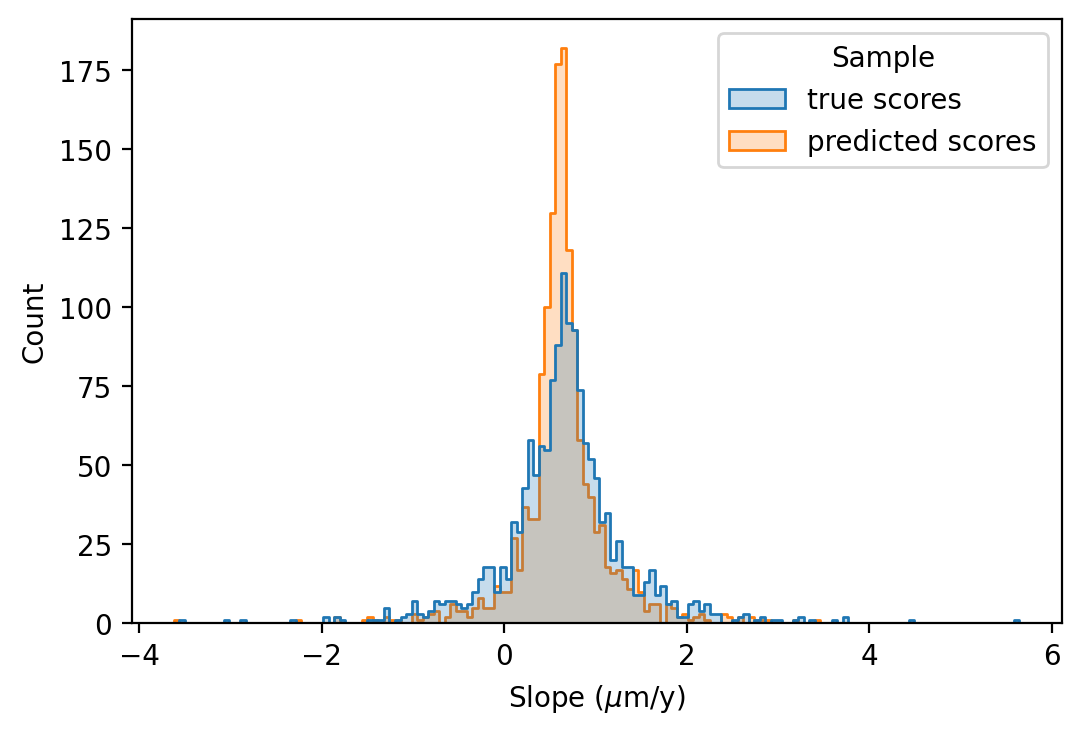

In [11]:
from scipy.stats import ks_2samp
dfx = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': true_scores.ravel().tolist(), 'Sample':'true scores'})
dfy = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': pred_scores.ravel().tolist(), 'Sample':'predicted scores'})
df = pd.concat(axis=0, ignore_index=True, objs=[dfx,dfy])



fig,ax = plt.subplots()
sns.histplot(df,x='Slope ($\mu$m/y)',hue='Sample',ax=ax, element='step')


In [12]:
import pandas as pd
import numpy as np
df.to_csv('predscores.csv')
ndf = pd.DataFrame({'ep': ep,
'train': trainloss,
'valid': validloss,'total':totloss})
ndf.to_csv('losses.csv')

ndf = pd.DataFrame({'ep': testep, 'test':testloss})
ndf.to_csv('testl.csv')

true = np.array(df[df['Sample'] == 'true scores']['Slope ($\mu$m/y)'].tolist())
pred = np.array(df[df['Sample'] == 'predicted scores']['Slope ($\mu$m/y)'].tolist())

from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(true, pred)
print(coefficient_of_dermination)


0.5048827087975689


In [13]:
import scipy
def rsquared(x, y):

    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

In [14]:
rsquared(true, pred)

0.5055161949297573

In [15]:
scipy.stats.spearmanr(true, pred)

SpearmanrResult(correlation=0.6645858214511147, pvalue=1.5511190883034003e-189)

In [16]:
scipy.stats.pearsonr(true, pred)

(0.7109966208989724, 1.371247290185372e-228)